## Introduction

This tutorial is for explaining algorithms with xgboost and arima, even there are two different subject one with classification and the other is for time series, but as there will be a project that need these two algorithms, so this is for explaining the algorithms and use case for how do we use them.

As for xgboost, this is really a famous algorithm that is used in kaggle, in real product, I have used it once in real production, this algorithm is based on boost algorithm, for boost logic, you have to know what is boost and voting logic. 

For both logic, we won't just train one model, we train many models based on data, suppose we have 10 models trained, but for voting logic, we will create 10 sample dataset from training data, like we have 10000 samples, we could get 9000 samples with shuffling(make data into different order everytime), so that we could get 10 different datasets, then we could train 10 models based on different data, we could get 10 different prediction results for each record of test data based on these 10 models, like we have 10 samples, we will get 10 * 10 results, each sample will have 10 different prediction result, like two classification problem, the prediction result is [1, 1, 1, 1, 0, 0, 0, 0, 0, 0], then for voting logic is to get most frequent class, that's `0`, so we could get prediction with `0` as result. That's voting, the representive algorithm is `Random Forest`. 

But with boosting is different, the logic is first we could train our first model based on whole data, currently for each sample will give equal weight, then we will get prediction result based on training data, we will get correct and wrong prediction for each sample, then for second model, we could give different weight for each sample, for correctly prediction record, will give less weight, for wrong record will give higher weight, so that we could let second model to pay more attention to the wrong records, the rest is same. The representative algorithm is `Gradient boosting`, the `XGBoost` is similiar with `Gradient Boosting`, but is more accurate than `Gradient Boosting`.

That's voting and boosting algorithm, but the detail algorithm could be found in [official website](https://xgboost.readthedocs.io/en/latest/get_started.html).

For Arima algorithm is for time series, what's time series? The most common use case is like stock prediction, in fact, we have to consider so many feature in real stock prediction, but if we just want to find the logic in just stock price with time being change, that's time series. 

For current algorithm with time series, ARIMA is most common choice. For the main logic, I recommand you [ARIMA explain](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/). 

That's for high level explaination, let's show code for how to use them.

In [1]:
# first we have to install xgboost first, with pip would be fine.
# but currently with colab, we already have the xgboost.
# if you try to code in local server, you have to use `pip install xgboost` with `!` in windows terminal.
! pip install xgboost

# shift +enter.

Active code page: 65001


In [2]:
# import libraries
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# with iris data
x, y = load_iris(return_X_y = True)

# let's make it into dataframe
df = pd.DataFrame(np.concatenate((x, y[:, np.newaxis]), axis=1), columns=['a', 'b', 'c', 'd', 'label'])

df.head()


,a,b,c,d,label
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [0]:
# # let's get data and labels with train and test
# # I find that we have to make the label into one-hot 
# from sklearn.preprocessing import OneHotEncoder

# y_onehot = OneHotEncoder().fit_transform(y[:, np.newaxis])

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=.2, random_state=1234)

# construct with DMatrix object, as xgboost not support fit(xtrain, ytrain), but I have to 
# say that we could use sklearn wrap with xgboost, then could use `fit`
train_data = xgb.DMatrix(data=xtrain, label=ytrain)
test_data = xgb.DMatrix(data=xtest, label=ytest)

## Tips

for xgboost, we may first set some parameters important thing to remember: when we try to solve multi-class, we have to set our object with`multi:softmax`, without any space. Also we have to set manually with `num_class` parameter, otherwise will face error:[xgboost sklearn wrapper value 0for Parameter num_class should be greater equal to 1](https://stackoverflow.com/questions/40116215/xgboost-sklearn-wrapper-value-0for-parameter-num-class-should-be-greater-equal-t).

In [87]:
param = {'max_depth': 3, 'eta': 1, 'objective': 'multi:softmax', 'num_class' : 3}   # we have 3 classes

# how many epochs we would use to train model
num_round = 3

# let's train with our training data.
bst = xgb.train(param, train_data, num_boost_round=num_round)

# so we have already trained our model, let's test it.
pred_test = bst.predict(test_data)

# let's get some sample results
print("Prediction result:", pred_test[:10])

Prediction result: [1. 1. 2. 0. 1. 0. 0. 0. 1. 2.]


In [88]:
# let's get predictio metrics
from sklearn.metrics import accuracy_score

# so far so good, we get 100% accuracy
print("Accuracy: ", accuracy_score(ytest, pred_test.astype(np.int)))

Accuracy:  1.0


In [89]:
# let's try with xgboost sklearn wrapper, the logic is same as above just with different method
# to train model, but with a easier way like sklearn
clf = xgb.XGBClassifier(objective='multi:softmax', n_estimators=10, max_depth=3, learning_rate=.1)

# let's train our model
clf.fit(xtrain, ytrain)

# get prediction
pred_sk_wrapper = clf.predict(xtest)

print("Sample prediction:", pred_sk_wrapper[:10])

# that's it. So you could find that we also get 100% accuracy, so if you are familiar with 
# sklearn, I really recommand with use sklearn wrapper to do training, as it's really easy to use.
print("Accuracy:  ", accuracy_score(ytest, pred_sk_wrapper))

Sample prediction: [1 1 2 0 1 0 0 0 1 2]
Accuracy:   1.0


## Let's meet ARIMA

As I have mentioned that ARIMA is for time series, so we don't use any other information to do prediction but with just inherent data logic with subtraction of different timestamp, like we have 5 days data, from date `2010-01-01`
 to `2020-01-05`, target data is [1, 2, 3, 4, 5], then we could move the train data with one day, means second column with first value is `NAN`, second value will be the value of `2020-01-01`, likewise the second column is [NAN, 1, 2, 3, 4], the last 5 will be dropped, if we move 2 days, the third column is [NAN, NAN, 1, 2, 3], the `4 and 5` will be dropped. That's the high level overview of ARIMA.


Let's take a sample dataset with time series.

In [0]:
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt

# let's import with statsmodel for ARIMA algorithm
# statsmodels.tsa, `tsa` means time series analysis
from statsmodels.tsa.arima_model import ARIMA
import datetime



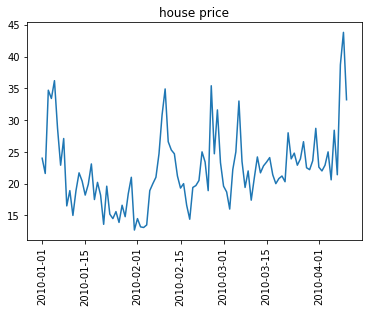

In [92]:
# this is house price range
# NOTED: if we use x as features, than that's regression problem, but we just use y.
# also if we need to use ARIMA, the data should be seasonal change, but currently data isn't
# but this is for tutorial...
x, y = load_boston(return_X_y=True)

# get 100 records.
y = y[:100]

# let's make the time range periods.
time_range = pd.date_range(start='2010-01-01', periods=len(y))

df = pd.DataFrame(y[:, np.newaxis], columns=['label'])

# we could set the dataframe index with data, so that we could find the data vary with time.
df = df.set_index(time_range)
df.head()

# let's plot it 
plt.plot(df.index, df['label'])
plt.xticks(rotation=90)  # set x label with 90 rotation.
plt.title('house price')

# that's how our time data range that we need to process.
# the data is varied within time periods
plt.show()

In [93]:
# with statsmodel training is really easy, with one line should be fine
# before we train our model, we have to split our data into train and test data.
# but this is time series, then we have to get data with previous data as train
# later data as test data

train_time = df.iloc[:90, :]
test_time = df.iloc[90:, :]

# so that we get 90 records as train, 10 records as test data.
print("Training data size: ", len(train_time))
print('Test data size:', len(test_time))

# start our model training
model = ARIMA(train_time, order=(2, 1, 0)).fit(disp=0)

# we could get the summary of the model based on training data.
# if you are not famaliar with statistics, you could just ignore it. 
# but you could know that we could get some smmaries from trained model.
print(model.summary())

Training data size:  90
Test data size: 10
                             ARIMA Model Results                              
Dep. Variable:                D.label   No. Observations:                   89
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -257.178
Method:                       css-mle   S.D. of innovations              4.349
Date:                Tue, 02 Jun 2020   AIC                            522.357
Time:                        05:01:21   BIC                            532.311
Sample:                    01-02-2010   HQIC                           526.369
                         - 03-31-2010                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0445      0.342      0.130      0.897      -0.625       0.714
ar.L1.D.label    -0.3491      0.106     -3.278      0.002      -0.558      -0.1

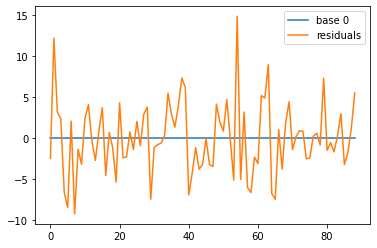

In [94]:
 # we could also plot training prediction result, as we trained one model,
 # we could also get the prediction of training data, to compare between target and prediction.
 # the `resid` means residual, how much difference between true and prediction data.
 residuals = pd.DataFrame(model.resid, columns=['residual'])
 plt.plot([0] * len(residuals), label='base 0')
plt.plot(residuals['residual'].values, label='residuals')
plt.legend()

# if we get whole data residual with 0, then means we fit our model perfectly.
plt.show()

In [95]:
# get summary of residuals
residuals.describe()

,residual
count,89.000000
mean,-0.008936
std,4.374732
min,-9.223511
25%,-2.699928
50%,-0.085322
75%,2.925018
max,14.860664


In [96]:
# After we have trained our model, let's get prediction based on our trained model
# One thing to notice is that we should get prediction based on `time`.
# also we should provide with training data appended with prediction records
# the reason why we need to append our prediction result into the history list is
# we need to get the next 2 days prediction based on history data + next 1 day data.
# that means we could just predict next day's result.
import copy

# let's get varous training data, make it into a list
history = [x for x in train_time['label']]

# to save our prediction result.
predictions = list()

for i in range(len(test_time)):
  model = ARIMA(history, order=(2, 1, 0)).fit(disp=0)
  output = model.forecast()[0]     # get next timestamp prediction
  predictions.append(output)
  truth = test_time['label'].iloc[i]
  history.append(truth)
  print("predicted={:.2f}, expected={}".format(output[0], truth))

predicted=26.97, expected=22.6
predicted=24.76, expected=22.0
predicted=22.31, expected=22.9
predicted=22.58, expected=25.0
predicted=24.24, expected=20.6
predicted=22.11, expected=28.4
predicted=25.62, expected=21.4
predicted=23.97, expected=38.7
predicted=31.39, expected=43.8
predicted=42.79, expected=33.2


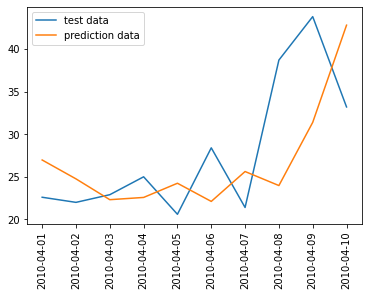

In [97]:
# let's plot our result for different time.
x_time = test_time.index.tolist()
plt.plot(x_time, test_time['label'].values, label='test data')
plt.plot(x_time, predictions, label='prediction data')

plt.xticks(rotation=90)
plt.legend()
plt.show()

### Get prediction with just one step training

in fact, you could find that currently we get prediction is based on every time prediction result and train another model, but let's just create a model based on our train data, and get prediction of next 10 days. Also you could change the `order` parameter in ARIMA as you want to test for show case whether is good.

I have to say that with just one trained model and  test prediction won't get a good result, why? The reason is for ARIMA, the best suited situation is data is relational within time, but our sample data isn't, the second reason is based on just past data to predict so many days, it's that reasonable than get prediction and next day, and put next day result into past data and train model again, so that model could get more reasonable result. But in real production, which way to choose? It depends. If we could make the model trained every day, get best model, then we will get better result, otherwise we are not that confident about so long future prediction, keep this in mind.

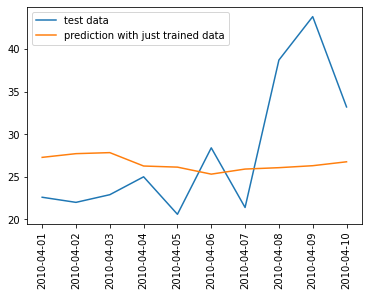

In [139]:
# in fact, you could find that currently we get prediction is based on every time prediction result
# and train another model, but let's just create a model based on our train data, and get prediction
# of next 10 days.
# also you could change the `order` parameter as you want to test for show case whether is good.
model_trained = ARIMA(train_time, order=(6, 1, 0)).fit(disp=0)

pred_trained = model_trained.forecast(steps=len(test_time))[0]

test_time_index = test_time.index

plt.plot(test_time_index, test_time, label='test data')
plt.plot(test_time_index, pred_trained, label='prediction with just trained data')

plt.xticks(rotation=90)
plt.legend()
plt.show()

## Tuning model

We haven't coverred how to choose best parameters based on training data, we have to keep in mind that we have to try to best best parameters with optimizer logic everytime the data changed. 

Here I could use `Grid search` logic to find the best hyper-parameters for ARIMA, important thing to notice we have to choose a metric to evaluate how are model is trained, there are many ways like we could get prediction for test data with RMSE(root mean squared error: sum((y - pred)**2)) etc. But with statsmodel, there is metric attribution called: [AIC (Akaike Information Criterion) and BIC (Bayes Information Criterion)](https://github.com/gmonaci/ARIMA/blob/master/time-series-analysis-ARIMA.ipynb). 

Let's show code.

In [147]:
import itertools

q = d = range(0, 2)
p = range(3, 5) 

aic_list = list()
bic_list = list()

# get different combination
pdq = list(itertools.product(p, d, q))
print("Tuned parameters:", pdq)

for param in pdq:
  print("Training param: ", param)
  mod = ARIMA(train_time, order=param).fit(disp=0)
  aic_list.append(mod.aic)
  bic_list.append(mod.bic)

Tuned parameters: [(3, 0, 0), (3, 0, 1), (3, 1, 0), (3, 1, 1), (4, 0, 0), (4, 0, 1), (4, 1, 0), (4, 1, 1)]
Training param:  (3, 0, 0)
Training param:  (3, 0, 1)
Training param:  (3, 1, 0)
Training param:  (3, 1, 1)
Training param:  (4, 0, 0)
Training param:  (4, 0, 1)
Training param:  (4, 1, 0)
Training param:  (4, 1, 1)


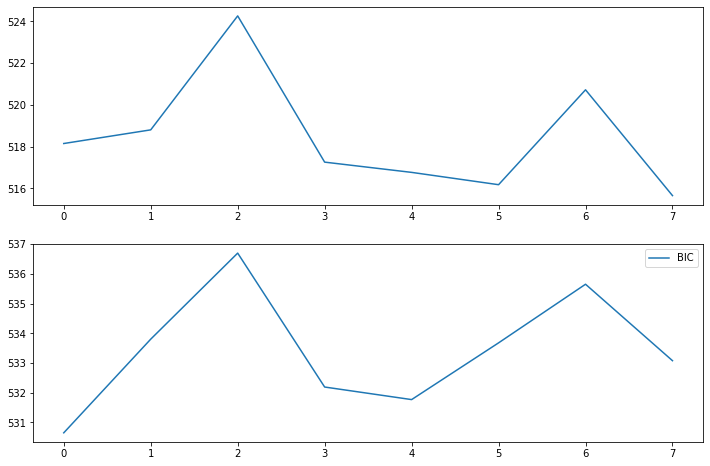

In [162]:
# after we have trained whole parameters, let's try to get best params for `order`
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

ax[0].plot(range(len(aic_list)), aic_list, label='AIC')
ax[1].plot(range(len(bic_list)), bic_list, label='BIC')

plt.legend()
plt.show()

Best parameters:  (4, 1, 1)


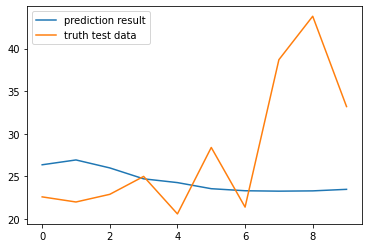

In [169]:
# we could use minimum AIC best value as best model parameter
best_param = pdq[aic_list.index(min(aic_list))]
print("Best parameters: ", best_param)

best_arima_model = ARIMA(train_time, order=best_param).fit()

# get prediction
best_pred = best_arima_model.forecast(steps=len(test_time))[0]

plt.plot(best_pred, label='prediction result')
plt.plot(test_time.values, label='truth test data')

plt.legend()
plt.show()


## Final words

As we have already create the whole thing about XGBoost and ARIMA, but we haven't dive deep into the algorithm, as the first thing is that we need to use it first, then we could get deep insight about how these algorithms work, that's a long way. But you could find that with code, it isn't that difficult. 

So maybe you could first try to code above, then you could get some understanding of yourself.